## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tqdm.notebook import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/ML Project/Womens Clothing E-Commerce Reviews.csv')

## Data Preprocessing

In [4]:
df.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

Drop Some Features

In [5]:
df = df.drop(['Unnamed: 0', 'Clothing ID', 'Positive Feedback Count', 'Division Name'], axis=1)

Combine Title and Review Only

In [6]:
df['Combined Text'] = df.apply(lambda row: f"{row['Title']}. {row['Review Text']}" if not pd.isna(row['Title']) else f"{row['Review Text']}", axis=1)

Lowercase

In [7]:
df['Combined Text'] = df['Combined Text'].str.lower()

In [8]:
df.shape

(23486, 8)

In [9]:
df.head(5)

,Age,Title,Review Text,Rating,Recommended IND,Department Name,Class Name,Combined Text
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,Intimate,Intimates,absolutely wonderful - silky and sexy and comf...
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,Dresses,Dresses,love this dress! it's sooo pretty. i happene...
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,Dresses,Dresses,some major design flaws. i had such high hopes...
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,Bottoms,Pants,"my favorite buy!. i love, love, love this jump..."
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,Tops,Blouses,flattering shirt. this shirt is very flatterin...


In [10]:
df['Recommended IND'].value_counts(normalize = True)

1    0.822362
0    0.177638
Name: Recommended IND, dtype: float64

Train-Validation-Test Split

In [11]:
X = df['Combined Text'].values
y = df['Recommended IND'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
  )

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train.shape, X_val.shape, X_test.shape

((16440,), (3523,), (3523,))

## Data Formatting

In [12]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Find Max Token Length

In [13]:
token_length = np.array([len(tokenizer.encode(row, add_special_tokens=True)) for row in tqdm(X)])
max_token_length = max(token_length)

  0%|          | 0/23486 [00:00<?, ?it/s]

In [14]:
X_train_tokens = tokenizer(
    X_train.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [15]:
X_val_tokens = tokenizer(
    X_val.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [16]:
X_test_tokens = tokenizer(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

## Model Architecture

1. Input Layer:
  * Shape: (max_token_length,)
  * Takes input ids and attention masks.

2. BERT Layer:
  * Pre-Trained BERT model for sequence classification.
  * Produces 'logits' as pooled output.

3. Output Layer:
  * Dense layer with Sigmoid activation function (1 unit).

In [17]:
def create_model():
    input_ids = Input(shape=(max_token_length,), dtype=tf.int32)
    attention_mask = Input(shape=(max_token_length,), dtype=tf.int32)

    bert_model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
    outputs = bert_model([input_ids, attention_mask])
    pooled_output = outputs['logits']

    output_layer = Dense(1, activation='sigmoid')(pooled_output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    return model

Training Parameters (Recommended in BERT Paper published by Google):
* Optimizer: Adam
* Learning Rate: 2e-5
* Epochs: 4
* Batch Size: 32

In [18]:
optimizer = Adam(learning_rate=2e-5)
model = create_model()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 169)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 169)]                0         []                            
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1094837   ['input_1[0][0]',             
 ification (TFBertForSequen  (loss=None, logits=(None,    78         'input_2[0][0]']             
 ceClassification)           2),                                                                  
                              hidden_states=None, atten                                       

In [ ]:
history = model.fit(
    [X_train_tokens['input_ids'], X_train_tokens['attention_mask']],
    y_train,
    epochs=4,
    batch_size=32,
    validation_data=([X_val_tokens['input_ids'], X_val_tokens['attention_mask']], y_val),
)

Epoch 1/4
514/514 [==============================] - 632s 1s/step - loss: 0.2375 - accuracy: 0.9041 - val_loss: 0.1732 - val_accuracy: 0.9256
Epoch 2/4
514/514 [==============================] - 588s 1s/step - loss: 0.1422 - accuracy: 0.9428 - val_loss: 0.1694 - val_accuracy: 0.9313
Epoch 3/4
514/514 [==============================] - 629s 1s/step - loss: 0.0947 - accuracy: 0.9653 - val_loss: 0.1894 - val_accuracy: 0.9381
Epoch 4/4
514/514 [==============================] - 629s 1s/step - loss: 0.0585 - accuracy: 0.9811 - val_loss: 0.2240 - val_accuracy: 0.9310


Save Weights

In [ ]:
model.save_weights('/content/gdrive/MyDrive/ML Project/Weights/BERT Base (Recommended IND) without Novelty.h5')

## Evaluation

Load Saved Weights

In [19]:
optimizer = Adam(learning_rate=2e-5)
model = create_model()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
model.load_weights('/content/gdrive/MyDrive/ML Project/Weights/BERT Base (Recommended IND) without Novelty.h5')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 169)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 169)]                0         []                            
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1094837   ['input_3[0][0]',             
 ification_1 (TFBertForSequ  (loss=None, logits=(None,    78         'input_4[0][0]']             
 enceClassification)         2),                                                                  
                              hidden_states=None, atten                                     

In [20]:
y_pred = model.predict([X_test_tokens['input_ids'], X_test_tokens['attention_mask']])
y_pred_binary = (y_pred > 0.5).astype(int)

111/111 [==============================] - 41s 345ms/step


In [21]:
accuracy_score(y_test, y_pred_binary)

0.9279023559466364

In [22]:
precision_score(y_test, y_pred_binary)

0.9527235354573484

In [23]:
recall_score(y_test, y_pred_binary)

0.959958577839144

In [24]:
f1_score(y_test, y_pred_binary)

0.9563273727647869

In [25]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       626
           1       0.95      0.96      0.96      2897

    accuracy                           0.93      3523
   macro avg       0.88      0.87      0.87      3523
weighted avg       0.93      0.93      0.93      3523



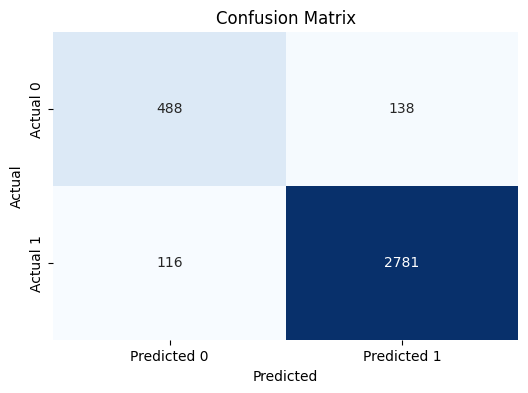

In [26]:
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()